## Import module

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StringType, DoubleType

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.feature import PCA as PCAml
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
import itertools
import os
import missingno as msno

import findspark
findspark.init()

spark=SparkSession.builder \
        .master ("local[*]")\
        .appName("part3")\
        .getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Users\kalpe\Anaconda3\lib\site-packages\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
def transData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).\
           toDF(['label','features'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_dummy(df,categoricalCols,continuousCols,labelCol):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

def get_dummy_unsupervised(df,categoricalCols,continuousCols):

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    return data.select('features')

## Load Data

In [3]:
df = spark.read.option("header", "true").option("sep",";").csv("XYZ_Bank_Deposit_Data_Classification.csv")

In [4]:
df = df.withColumnRenamed("emp.var.rate","emp_var_rate") \
    .withColumnRenamed("cons.price.idx","cons_price_idx") \
    .withColumnRenamed("cons.conf.idx","cons_conf_idx") \
    .withColumnRenamed("nr.employed","nr_employed") \

df = df.withColumn("age",df.age.cast('int'))
df = df.withColumn("duration",df.duration.cast('int'))
df = df.withColumn("campaign",df.campaign.cast('int'))
df = df.withColumn("pdays",df.pdays.cast('int'))
df = df.withColumn("previous",df.previous.cast('int'))
df = df.withColumn("emp_var_rate",df.emp_var_rate.cast('float'))
df = df.withColumn("cons_price_idx",df.cons_price_idx.cast('float'))
df = df.withColumn("cons_conf_idx",df.cons_conf_idx.cast('float'))
df = df.withColumn("nr_employed",df.nr_employed.cast('float'))
df = df.withColumn("euribor3m",df.euribor3m.cast('float'))

# EDA

In [5]:
df_pan = df.toPandas()

catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

df_pan[num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000000,32.000000,38.000000,47.000000,98.000000
duration,41188.0,258.285010,259.279249,0.000000,102.000000,180.000000,319.000000,4918.000000
campaign,41188.0,2.567593,2.770014,1.000000,1.000000,2.000000,3.000000,56.000000
pdays,41188.0,962.475454,186.910907,0.000000,999.000000,999.000000,999.000000,999.000000
previous,41188.0,0.172963,0.494901,0.000000,0.000000,0.000000,0.000000,7.000000
emp_var_rate,41188.0,0.081885,1.571047,-3.400000,-1.800000,1.100000,1.400000,1.400000
cons_price_idx,41188.0,93.575661,0.579143,92.200996,93.074997,93.749001,93.994003,94.766998
cons_conf_idx,41188.0,-40.502602,4.628254,-50.799999,-42.700001,-41.799999,-36.400002,-26.900000
euribor3m,41188.0,3.621291,1.734434,0.634000,1.344000,4.857000,4.961000,5.045000
nr_employed,41188.0,5167.036133,72.287048,4963.600098,5099.100098,5191.000000,5228.100098,5228.100098


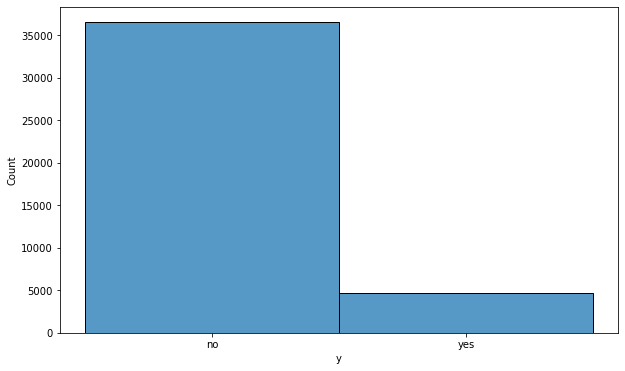

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(df_pan['y'])
plt.show()

<AxesSubplot:>

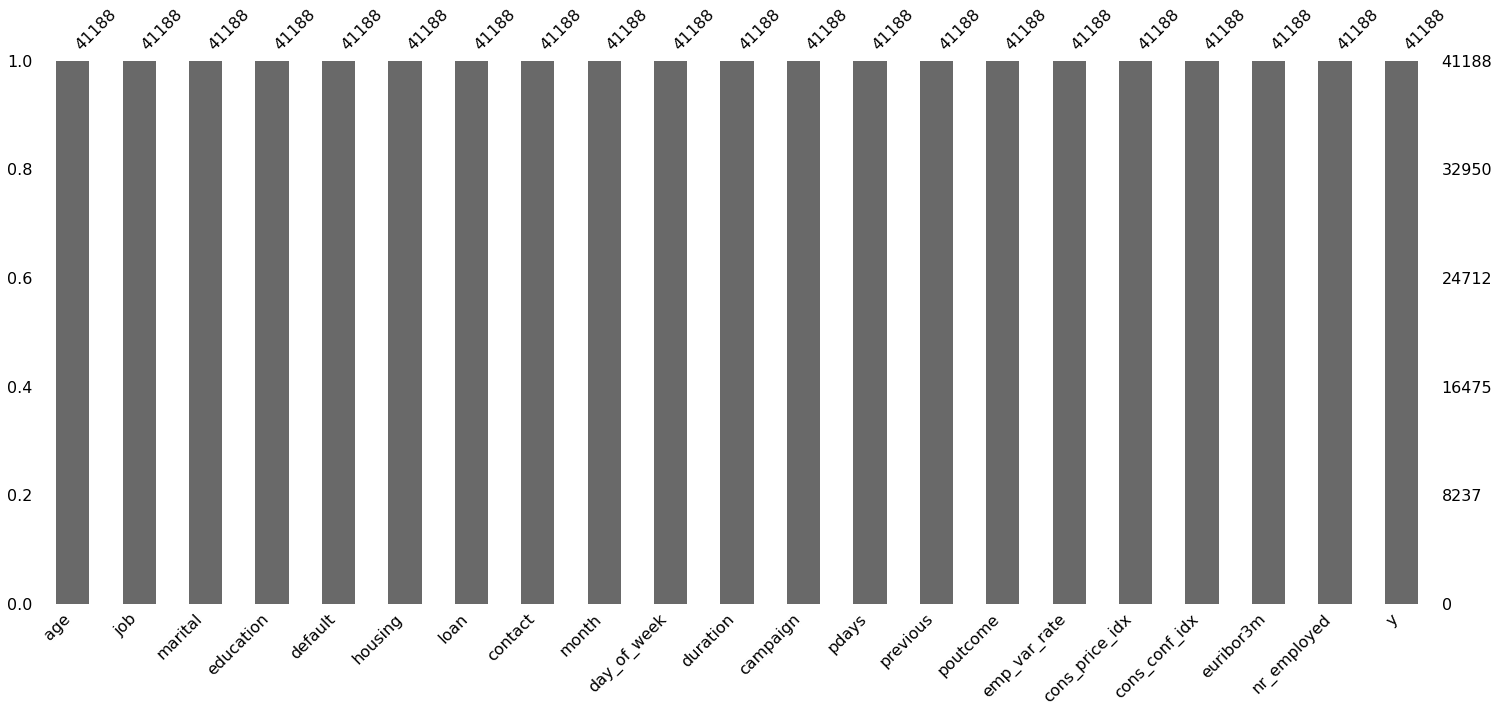

In [7]:
# Plot missing values
msno.bar(df_pan)

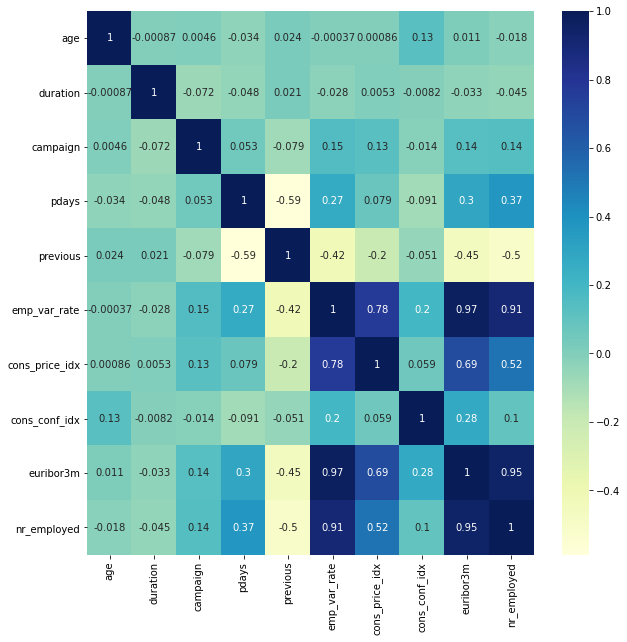

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df_pan[num_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()

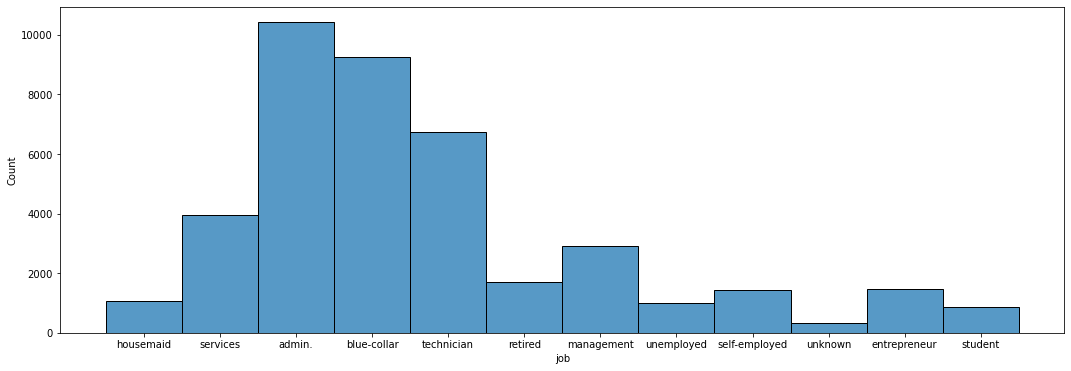

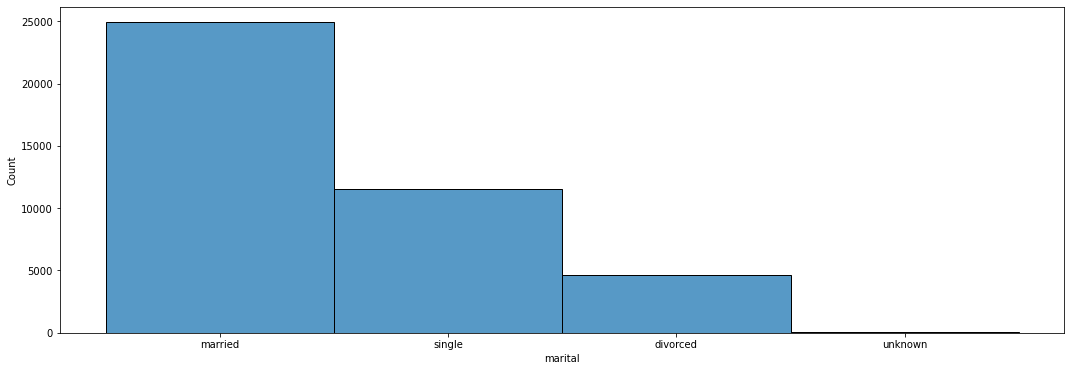

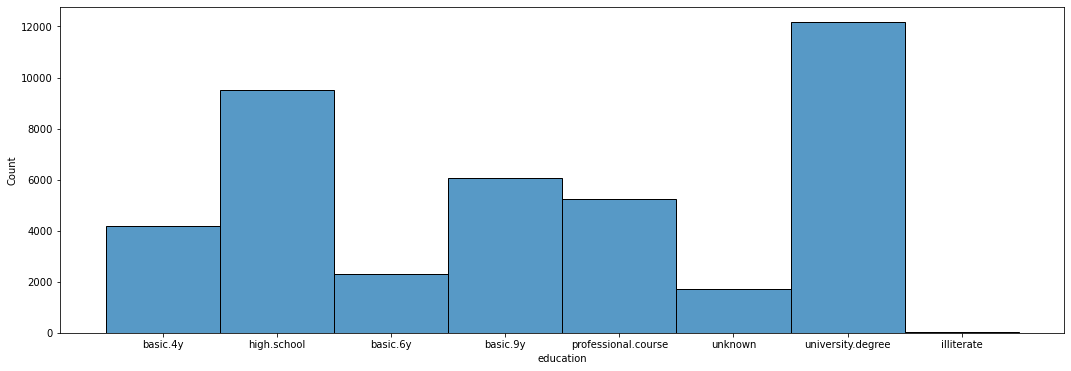

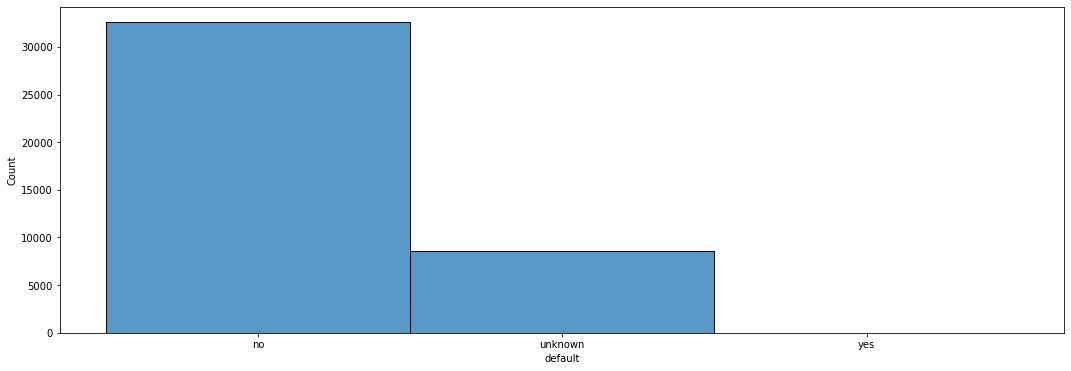

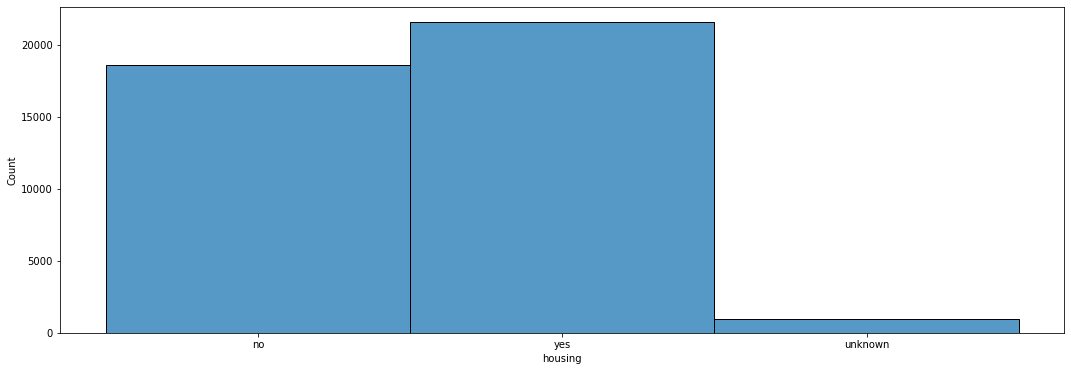

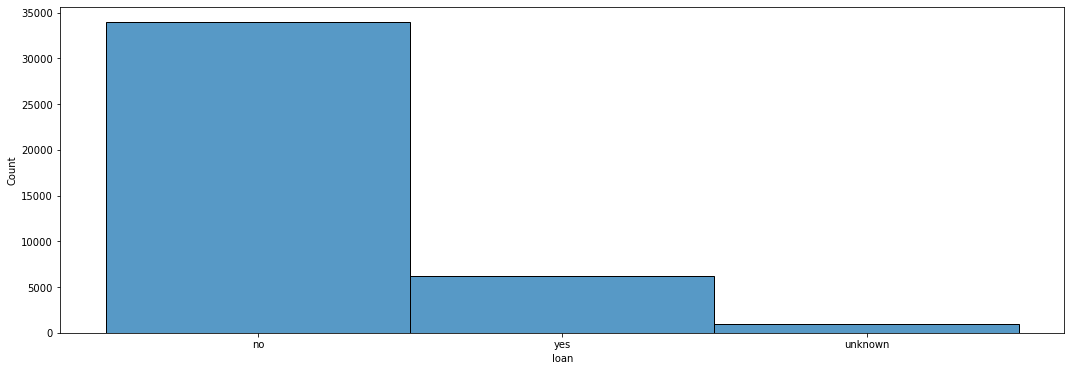

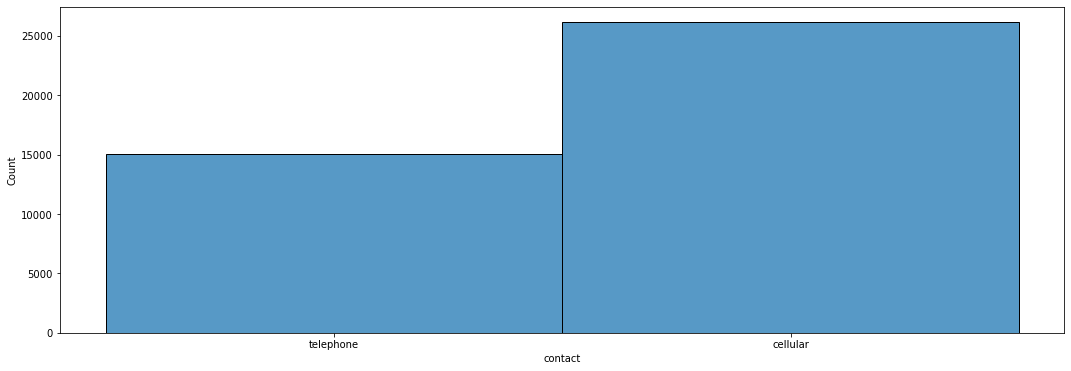

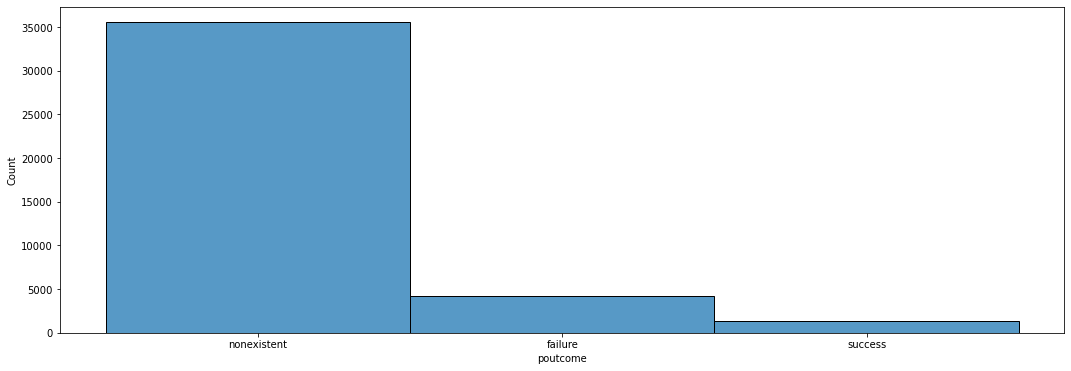

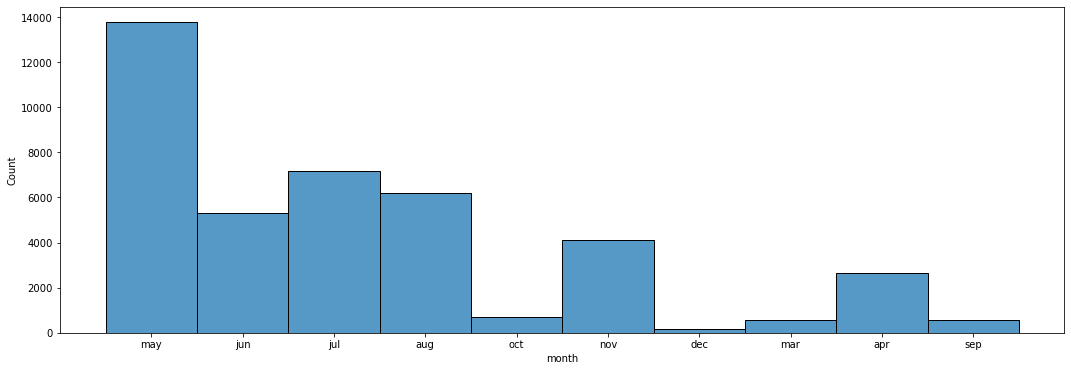

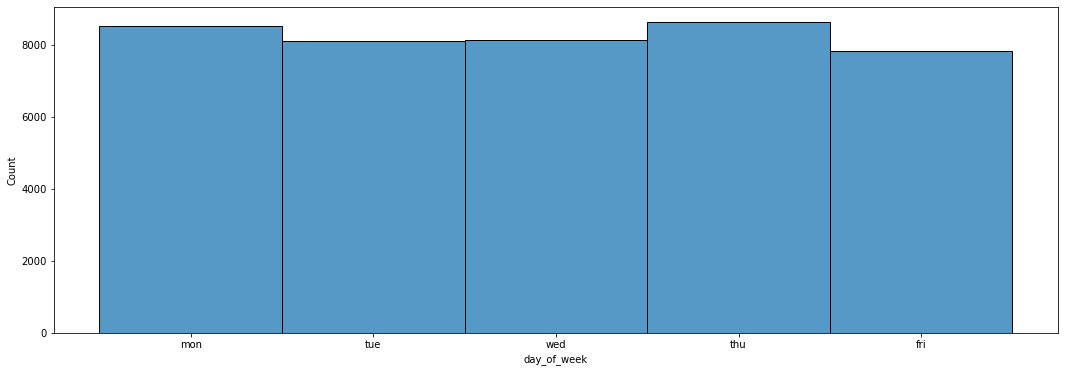

In [9]:
for i in catcols:
    plt.figure(figsize=(18,6))
    sns.histplot(df_pan[i])
    plt.show()

# Modelling

In [10]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

labelCol = 'y'

In [11]:
data = get_dummy(df, catcols, num_cols, labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(53,[8,11,18,21,2...|   no|
|(53,[3,11,15,22,2...|   no|
|(53,[3,11,15,21,2...|   no|
|(53,[0,11,19,21,2...|   no|
|(53,[3,11,15,21,2...|   no|
+--------------------+-----+
only showing top 5 rows



In [12]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(53,[8,11,18,21,2...|   no|         0.0|
|(53,[3,11,15,22,2...|   no|         0.0|
|(53,[3,11,15,21,2...|   no|         0.0|
|(53,[0,11,19,21,2...|   no|         0.0|
|(53,[3,11,15,21,2...|   no|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [13]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(53,[8,11,18,21,2...|   no|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|   no|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|   no|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|   no|(53,[3,11,15,21,2...|
+--------------------+-----+--------------------+
only showing top 5 rows



## Train-Test Split

In [14]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(3,False)
testData.show(3,False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                |label|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(53,[0,11,14,21,23,25,27,28,31,39,43,44,45,46,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,60.0,5.0,999.0,1.399999976158142,93.91799926757812,-42.70000076293945,4.9679999351501465,5228.10009765625]) |no   |
|(53,[0,11,14,21,23,25,27,28,31,39,43,44,45,46,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

## Logistic Regression

In [15]:
# Fit Logistic Regression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [16]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [17]:
# Save the model
model.write().overwrite().save("/model/lr_model.model")

Py4JJavaError: An error occurred while calling o1496.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 68 more


In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

### Evaluate

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Normalized confusion matrix
[[0.97085461 0.02914539]
 [0.56758242 0.43241758]]


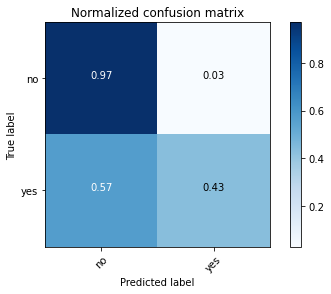

In [174]:
# Plot normalized confusion matrix
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Decision Trees

In [71]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [72]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree ,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Save the model
model.write().overwrite().save("/model/dTree_model.model")

In [73]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [74]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.0890539
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_5ad906481112, depth=5, numNodes=41, numClasses=2, numFeatures=53


Normalized confusion matrix
[[0.95832198 0.04167802]
 [0.45928685 0.54071315]]


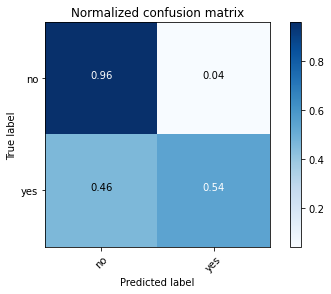

In [75]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Random Forest    

In [76]:
# Train a DecisionTree model
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [77]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf ,labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Save the model
model.write().overwrite().save("/model/rf_model.model")

In [78]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [79]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.098714
RandomForestClassificationModel: uid=RandomForestClassifier_879c6c04c88e, numTrees=20, numClasses=2, numFeatures=53


Normalized confusion matrix
[[0.99032961 0.00967039]
 [0.79457158 0.20542842]]


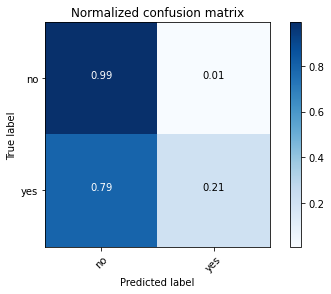

In [80]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Gradient Boosted Trees

In [97]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt, labelConverter])
# train the model
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Save the model
model.write().overwrite().save("/model/gbt_model.model")

In [98]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
|(53,[0,11,14,21,2...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



### Evaluate

In [99]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Predictions accuracy = %g, Test Error = %g" % (accuracy,(1.0 - accuracy)))

Predictions accuracy = 0.911791, Test Error = 0.0882087


Normalized confusion matrix
[[0.9645192 0.0354808]
 [0.5002661 0.4997339]]


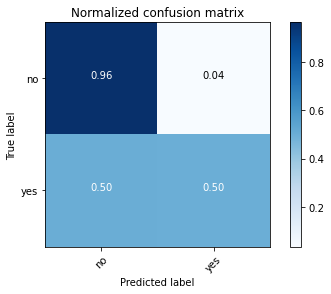

In [100]:
class_names = ['no', 'yes']

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## K-Means

In [145]:
df_cluster = df.drop("y")

In [147]:
catcols = ['job','marital','education','default',
           'housing','loan','contact','poutcome', 'month', 'day_of_week']

num_cols = ['age', 'duration','campaign','pdays','previous','emp_var_rate', 
            'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

In [148]:
data = get_dummy_unsupervised(df_cluster, catcols, num_cols)
data.show(5)

+--------------------+
|            features|
+--------------------+
|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|
+--------------------+
only showing top 5 rows



In [149]:
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(data)

data = featureIndexer.transform(data)

In [150]:
data.show(5,True)

+--------------------+--------------------+
|            features|     indexedFeatures|
+--------------------+--------------------+
|(53,[8,11,18,21,2...|(53,[8,11,18,21,2...|
|(53,[3,11,15,22,2...|(53,[3,11,15,22,2...|
|(53,[3,11,15,21,2...|(53,[3,11,15,21,2...|
|(53,[0,11,19,21,2...|(53,[0,11,19,21,2...|
|(53,[3,11,15,21,2...|(53,[3,11,15,21,2...|
+--------------------+--------------------+
only showing top 5 rows



### Silhouette for optimal-k

In [151]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol="indexedFeatures", \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='indexedFeatures', k=K)

    KMeans_fit=KMeans_.fit(data)

    KMeans_transform=KMeans_fit.transform(data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)


Text(0, 0.5, 'Silhouette Score')

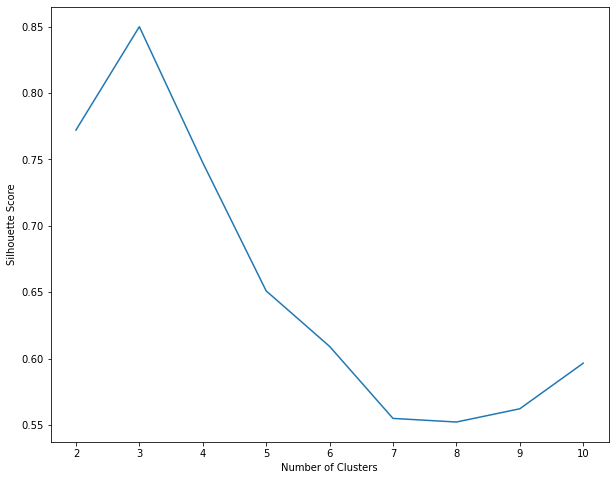

In [152]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [153]:
# Run KMeans
kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(data)

cluster = model.transform(data)

In [ ]:
# Save the model
model.write().overwrite().save("/model/kmeans_model.model")

### Visualize clusters

In [142]:
pca = PCAml(k=2, inputCol="indexedFeatures", outputCol="pca")
pca_model = pca.fit(data)
pca_transformed = pca_model.transform(data)

In [143]:
# extract the principal components
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())
# retrieve the cluster assignments from k-means assignments.
cluster_assignment = np.array(cluster.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1720.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1720.0 (TID 3130) (MSI.lan executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\sql\types.py", line 1897, in __getattr__
    idx = self.__fields__.index(item)
ValueError: 'prediction' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 686, in main
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 678, in process
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "C:\Users\scrmo\AppData\Local\Temp\ipykernel_4504\3963653930.py", line 4, in <lambda>
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\sql\types.py", line 1902, in __getattr__
    raise AttributeError(item)
AttributeError: prediction

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\sql\types.py", line 1897, in __getattr__
    idx = self.__fields__.index(item)
ValueError: 'prediction' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 686, in main
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 678, in process
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "C:\Users\scrmo\AppData\Local\Temp\ipykernel_4504\3963653930.py", line 4, in <lambda>
  File "C:\apps\spark-3.3.0-bin-hadoop3\python\lib\pyspark.zip\pyspark\sql\types.py", line 1902, in __getattr__
    raise AttributeError(item)
AttributeError: prediction

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
